In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.svm import SVC
from tqdm.notebook import tqdm
import time
from pickle import load, dump
import copy

# Data Generation

In [3]:
def checkerboard4(num_train, num_test, num_grid_col=4, num_grid_row=4, position=0):
    if num_train%2:
        raise ValueError(f"This method wants to create a balanced dataset but received"
                f"odd num_train={num_train}.")
    if num_test%2:
        raise ValueError(f"This method wants to create a balanced dataset but received"
                f"odd num_test={num_test}.")
    num_total = num_train + num_test
    max_samples = num_grid_row * num_grid_col * 40
    if num_total>max_samples:
        raise ValueError(f"Due to intricate legacy reasons, the number of samples"
                f"may not exceed {max_samples}. Received {num_total}.")
    # creating negative (-1) and positive (+1) samples
    negatives = []
    positives = []
    for i in range(num_grid_col):
        for j in range(num_grid_row):
            data = (np.random.random((40,2))-0.5)
            data[:,0] = (data[:,0]+2*i+1)/(2*num_grid_col)
            data[:,1] = (data[:,1]+2*j+1)/(2*num_grid_row)
            if i%2==j%2:
                negatives.append(data)
            else:
                positives.append(data)
    negative = np.vstack(negatives)
    positive = np.vstack(positives)

    # split the data
    np.random.shuffle(negative)
    np.random.shuffle(positive)

    X_train = np.vstack([negative[:num_train//2], positive[:num_train//2]])
    y_train = np.hstack([-np.ones((num_train//2)), np.ones((num_train//2))])
    X_test = np.vstack([negative[num_train//2:num_total//2], positive[num_train//2:num_total//2]])
    y_test = np.hstack([-np.ones((num_test//2)), np.ones((num_test//2))])

    r0 = [X_train, y_train, X_test, y_test]

    X_train_l = X_train[np.where(X_train[:,0] <= 0.5)]
    y_train_l = y_train[np.where(X_train[:,0] <= 0.5)]
    X_test_l = X_test[np.where(X_test[:,0] <= 0.5)]
    y_test_l = y_test[np.where(X_test[:,0] <= 0.5)]

    r1 = [X_train_l[np.where(X_train_l[:,1] <= 0.5)],y_train_l[np.where(X_train_l[:,1] <= 0.5)],X_test_l[np.where(X_test_l[:,1] <= 0.5)],y_test_l[np.where(X_test_l[:,1] <= 0.5)]]
    r3 = [X_train_l[np.where(X_train_l[:,1] >= 0.5)],y_train_l[np.where(X_train_l[:,1] >= 0.5)],X_test_l[np.where(X_test_l[:,1] >= 0.5)],y_test_l[np.where(X_test_l[:,1] >= 0.5)]]

    X_train_r = X_train[np.where(X_train[:,0] >= 0.5)]
    y_train_r = y_train[np.where(X_train[:,0] >= 0.5)]
    X_test_r = X_test[np.where(X_test[:,0] >= 0.5)]
    y_test_r = y_test[np.where(X_test[:,0] >= 0.5)]

    r2 = [X_train_r[np.where(X_train_r[:,1] <= 0.5)],y_train_r[np.where(X_train_r[:,1] <= 0.5)],X_test_r[np.where(X_test_r[:,1] <= 0.5)],y_test_r[np.where(X_test_r[:,1] <= 0.5)]]

    r4 = [X_train_r[np.where(X_train_r[:,1] >= 0.5)],y_train_r[np.where(X_train_r[:,1] >= 0.5)],X_test_r[np.where(X_test_r[:,1] >= 0.5)],y_test_r[np.where(X_test_r[:,1] >= 0.5)]]

    return r0, r1, r2, r3, r4

In [4]:
np.random.seed(43) # Seed, 43 was used for the paper results

In [5]:
num_train = 60 # Number of training datapoints
num_test = 60 # Number of test datapoints

num_random_params = 3 # Number of random parameter positions.
num_epochs = 100 # Number of epochs for target alignment training

xlims = [0, 1]
ylims = [0, 1]

In [6]:
r0, r1, r2, r3, r4 = checkerboard4(num_train, num_test, num_grid_row=4, num_grid_col=4,position=4)

In [7]:
X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]

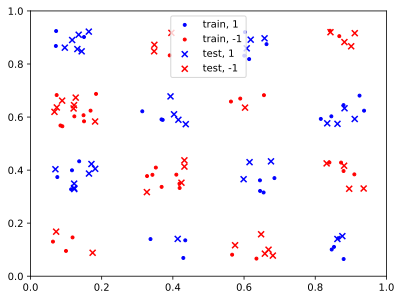

In [8]:
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()
plt.show()

# Gaussian Kernel Experiments

## Centralized training with Gaussian kernel

In [9]:
RBFsvm = SVC(kernel='rbf').fit(X_train, y_train)
precision = 200 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
prediction_r = RBFsvm.decision_function(X_grid)
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

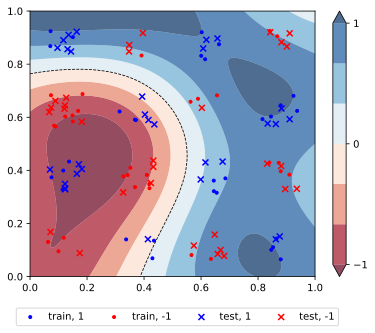

In [10]:
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

In [11]:
def prediction_accuracy(y_predicted, y_target):
    return 1 - np.count_nonzero(y_predicted - y_target) / len(y_target)

In [12]:
trained_train_predict = RBFsvm.predict(X_train)
trained_test_predict = RBFsvm.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on train", trained_train_accuracy)
print("with kernel training accuracy on test", trained_test_accuracy)

with kernel training accuracy on train 0.65
with kernel training accuracy on test 0.5166666666666666


## Local training with Gaussian kernel at node 1

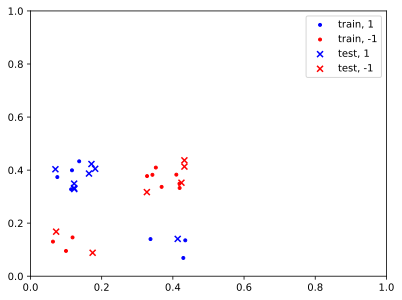

In [13]:
X_train, y_train, X_test, y_test = tuple(r1)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]


plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()
plt.show()

In [14]:
RBFsvm = SVC(kernel='rbf').fit(X_train, y_train)
precision = 200 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
prediction_r = RBFsvm.decision_function(X_grid)
z = np.reshape(prediction_r, xx.shape)

trained_train_predict = RBFsvm.predict(X_train)
trained_test_predict = RBFsvm.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on self_train", trained_train_accuracy)
print("with kernel training accuracy on self_test", trained_test_accuracy)

with kernel training accuracy on self_train 1.0
with kernel training accuracy on self_test 1.0


In [15]:
X_train, y_train, X_test, y_test = tuple(r0)

trained_test_predict = RBFsvm.predict(X_test)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on whole_test", trained_test_accuracy)

with kernel training accuracy on whole_test 0.5


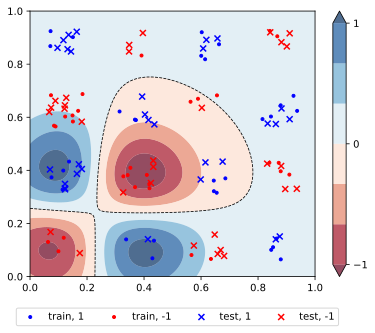

In [16]:
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Gaussian kernel at node 2

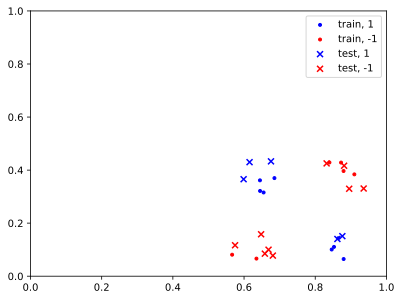

In [17]:
X_train, y_train, X_test, y_test = tuple(r2)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

In [18]:
RBFsvm = SVC(kernel='rbf').fit(X_train, y_train)
precision = 200 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
prediction_r = RBFsvm.decision_function(X_grid)
z = np.reshape(prediction_r, xx.shape)

trained_train_predict = RBFsvm.predict(X_train)
trained_test_predict = RBFsvm.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on self_train", trained_train_accuracy)
print("with kernel training accuracy on self_test", trained_test_accuracy)

with kernel training accuracy on self_train 0.8571428571428572
with kernel training accuracy on self_test 0.6428571428571428


In [19]:
X_train, y_train, X_test, y_test = tuple(r0)

trained_test_predict = RBFsvm.predict(X_test)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on whole_test", trained_test_accuracy)

with kernel training accuracy on whole_test 0.5666666666666667


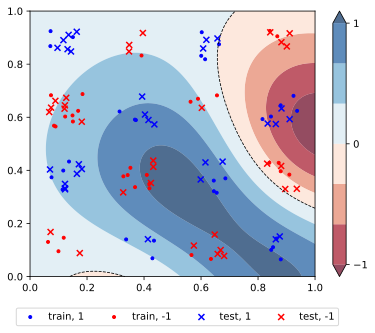

In [20]:
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Gaussian kernel at node 3

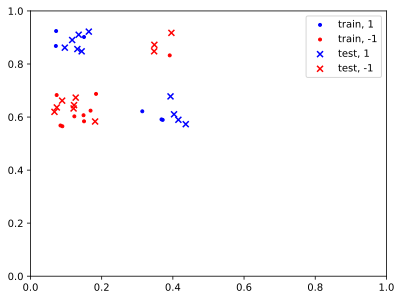

In [21]:
X_train, y_train, X_test, y_test = tuple(r3)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()
plt.show()

In [22]:
RBFsvm = SVC(kernel='rbf').fit(X_train, y_train)
precision = 200 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
prediction_r = RBFsvm.decision_function(X_grid)
z = np.reshape(prediction_r, xx.shape)

trained_train_predict = RBFsvm.predict(X_train)
trained_test_predict = RBFsvm.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on self_train", trained_train_accuracy)
print("with kernel training accuracy on self_test", trained_test_accuracy)

with kernel training accuracy on self_train 0.8666666666666667
with kernel training accuracy on self_test 0.85


In [23]:
X_train, y_train, X_test, y_test = tuple(r0)

trained_test_predict = RBFsvm.predict(X_test)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on whole_test", trained_test_accuracy)

with kernel training accuracy on whole_test 0.5166666666666666


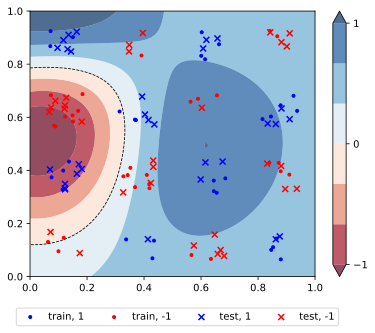

In [24]:
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Gaussian kernel at node 4

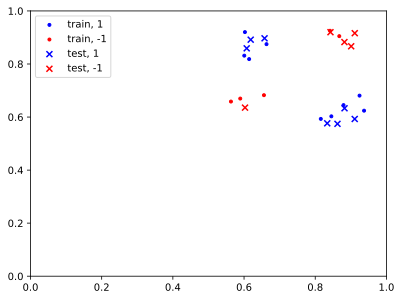

In [25]:
X_train, y_train, X_test, y_test = tuple(r4)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()
plt.show()

In [26]:
RBFsvm = SVC(kernel='rbf').fit(X_train, y_train)
precision = 200 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
prediction_r = RBFsvm.decision_function(X_grid)
z = np.reshape(prediction_r, xx.shape)

trained_train_predict = RBFsvm.predict(X_train)
trained_test_predict = RBFsvm.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on self_train", trained_train_accuracy)
print("with kernel training accuracy on self_test", trained_test_accuracy)

with kernel training accuracy on self_train 1.0
with kernel training accuracy on self_test 1.0


In [27]:
X_train, y_train, X_test, y_test = tuple(r0)

trained_test_predict = RBFsvm.predict(X_test)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on whole_test", trained_test_accuracy)

with kernel training accuracy on whole_test 0.5166666666666666


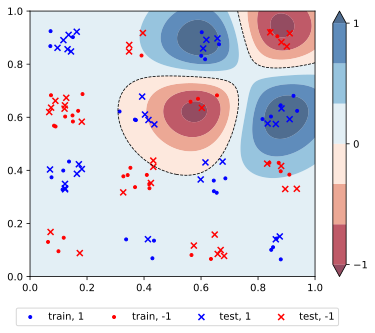

In [28]:
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

# Quantum kernel Training Preparation

In [29]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding Ansatz.
    Args:
        x (ndarray): Data to be embedded.
        params (ndarray): Trainable circuit parameters.
        wires (qml.Wires): Qubits to act on.
        i0 (int): Wire on which the first embedding rotation gate acts.
        inc (int): Increment between wires on which the embedding rotation gates act.
    Comments:
        Note that this circuit iterates cyclically over the feature vector to be embedded.
    """
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

    
def ansatz(x, params, wires):
    """The embedding Ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

        
def prediction_accuracy(y_predicted, y_target):
    return 1 - np.count_nonzero(y_predicted - y_target) / len(y_target)


def get_random_params(num_wires, num_layers):
    return np.random.uniform(0, 2*np.pi, (num_layers, 2, num_wires))


def target_alignment(X,Y,kernel,assume_normalized_kernel=False,rescale_class_labels=True):
    """Kernel-target alignment between kernel and labels."""
    K = qml.kernels.square_kernel_matrix(X,kernel,assume_normalized_kernel=assume_normalized_kernel)

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

In [30]:
num_wires = 5 # Number of qubits / Width of the circuit
num_layers = 8 # Number of building blocks / "Depth" of the circuit

## Local training with Quantum kernel at node 1

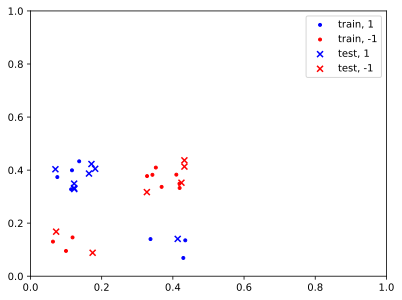

In [31]:
X_train, y_train, X_test, y_test = tuple(r1)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()
plt.show()

In [32]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

params = get_random_params(num_wires, num_layers)

with open('p_r1_ini.pickle', 'wb') as f:
    dump(params, f)

print(params)

[[[1.67354716 1.88257532 0.47310368 2.77884768 2.04122044]
  [0.30098155 3.78188609 4.31153436 1.56107652 3.5080661 ]]

 [[2.76990553 3.48230265 5.25883764 1.58259746 3.32220231]
  [3.8248559  0.96088569 2.26507307 5.24336505 0.71947915]]

 [[2.78253987 4.49483869 3.55283157 4.17915091 5.76778373]
  [4.0784258  4.13013459 4.8619063  6.27702849 1.17003983]]

 [[3.67845939 2.26115163 3.20029809 2.33907454 1.83530475]
  [1.26616284 1.64774481 0.97670352 0.37343631 3.94956317]]

 [[1.18026015 5.11978124 3.0304322  2.93449915 1.62917308]
  [1.38723649 1.92905872 1.20117701 2.62653324 6.11296619]]

 [[2.55201877 5.24971289 3.22062783 0.88692329 5.79326235]
  [0.91117399 5.6958069  3.08545232 5.16519468 2.321454  ]]

 [[2.62425451 1.30810004 3.85621591 3.17476628 1.76135199]
  [3.91567    6.12892323 5.56242829 4.49153866 3.66496649]]

 [[4.76465886 0.80552847 3.36765317 3.41585518 1.40441779]
  [1.24372229 5.85030332 5.88049846 3.88955981 4.08647437]]]


In [33]:
## fit the SVM on the training data
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
start = time.time()
svm_untrained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
end = time.time()
print (str(end-start))
## evaluate on the test set
rp_tr = svm_untrained_kernel.predict(X_train)
rp_te = svm_untrained_kernel.predict(X_test)
untrained_accuracy_train = prediction_accuracy(rp_tr, y_train)
untrained_accuracy_test = prediction_accuracy(rp_te, y_test)
print("without kernel training accuracy", untrained_accuracy_test)
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

Canonical path for scipy.libs threw exception:
filesystem error: cannot make canonical path: No such file or directory [/home/ronit/.local/lib/python3.12/site-packages/pennylane_lightning/lightning_qubit_ops.cpython-312-x86_64-linux-gnu.so../../scipy.libs/]


RuntimeError: filesystem error: directory iterator cannot open directory: No such file or directory [/home/ronit/.local/lib/python3.12/site-packages/pennylane_lightning/lightning_qubit_ops.cpython-312-x86_64-linux-gnu.so../../scipy.libs/]

In [ ]:
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

In [35]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

X_train, y_train, X_test, y_test = tuple(r1)

num_epochs = 1000 # Number of epochs for target alignment training

training_alignment = []
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
training_alignment.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
#opt = qml.GradientDescentOptimizer(2)
opt = qml.NesterovMomentumOptimizer(2)
# opt = qml.AdamOptimizer(2)
# opt = qml.QNGOptimizer(2)
for i in tqdm(range(num_epochs)):
    # We train on a small random subset of the training data set
    start = time.time()
    subset = np.random.choice(list(range(len(X_train))), 4)
    mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
    params = opt.step(mapped_neg_alignment, params)
    end = time.time()
    # print (str(end-start))
    if (i+1) % 50 == 0:
        mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
        alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
        training_alignment.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
trained_params = params.copy()

with open('p_r1_tra.pickle', 'wb') as f:
    dump(trained_params, f)

x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

Canonical path for scipy.libs threw exception:
filesystem error: cannot make canonical path: No such file or directory [/home/ronit/.local/lib/python3.12/site-packages/pennylane_lightning/lightning_qubit_ops.cpython-312-x86_64-linux-gnu.so../../scipy.libs/]


RuntimeError: filesystem error: directory iterator cannot open directory: No such file or directory [/home/ronit/.local/lib/python3.12/site-packages/pennylane_lightning/lightning_qubit_ops.cpython-312-x86_64-linux-gnu.so../../scipy.libs/]

In [ ]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)


precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Quantum kernel at node 2

In [ ]:
X_train, y_train, X_test, y_test = tuple(r2)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

In [ ]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

params = get_random_params(num_wires, num_layers)

with open('p_r2_ini.pickle', 'wb') as f:
    dump(params, f)

# print(params)
## fit the SVM on the training data
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
start = time.time()
svm_untrained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
end = time.time()
print (str(end-start))
## evaluate on the test set
rp_tr = svm_untrained_kernel.predict(X_train)
rp_te = svm_untrained_kernel.predict(X_test)
untrained_accuracy_train = prediction_accuracy(rp_tr, y_train)
untrained_accuracy_test = prediction_accuracy(rp_te, y_test)
# print("without kernel training accuracy", untrained_accuracy_test)
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

In [ ]:
dev = qml.device("default.qubit", wires=num_wires)
wires = list(range(num_wires))
# @qml.qnode(dev)
@qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

X_train, y_train, X_test, y_test = tuple(r2)

num_epochs = 1000 # Number of epochs for target alignment training

training_alignment = []
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
training_alignment.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
opt = qml.GradientDescentOptimizer(2)
# opt = qml.NesterovMomentumOptimizer(2)
# opt = qml.AdamOptimizer(2)
# opt = qml.QNGOptimizer(2)
for i in tqdm(range(num_epochs)):
    # We train on a small random subset of the training data set
    # start = time.time()
    subset = np.random.choice(list(range(len(X_train))), 4)
    mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
    params = opt.step(mapped_neg_alignment, params)
    # end = time.time()
    # print (str(end-start))
    if (i+1) % 50 == 0:
        mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
        alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
        training_alignment.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
trained_params = params.copy()

with open('p_r2_tra.pickle', 'wb') as f:
    dump(trained_params, f)

x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

In [ ]:
x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

In [ ]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Quantum kernel at node 3

In [ ]:
X_train, y_train, X_test, y_test = tuple(r3)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

In [ ]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

params = get_random_params(num_wires, num_layers)

with open('p_r3_ini.pickle', 'wb') as f:
    dump(params, f)

# print(params)
## fit the SVM on the training data
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
start = time.time()
svm_untrained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
end = time.time()
print (str(end-start))
## evaluate on the test set
rp_tr = svm_untrained_kernel.predict(X_train)
rp_te = svm_untrained_kernel.predict(X_test)
untrained_accuracy_train = prediction_accuracy(rp_tr, y_train)
untrained_accuracy_test = prediction_accuracy(rp_te, y_test)
# print("without kernel training accuracy", untrained_accuracy_test)
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

In [ ]:
dev = qml.device("default.qubit", wires=num_wires)
wires = list(range(num_wires))
# @qml.qnode(dev)
@qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

X_train, y_train, X_test, y_test = tuple(r3)

num_epochs = 1000 # Number of epochs for target alignment training

training_alignment = []
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
training_alignment.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
opt = qml.GradientDescentOptimizer(2)
# opt = qml.NesterovMomentumOptimizer(2)
# opt = qml.AdamOptimizer(2)
# opt = qml.QNGOptimizer(2)
for i in tqdm(range(num_epochs)):
    # We train on a small random subset of the training data set
    # start = time.time()
    subset = np.random.choice(list(range(len(X_train))), 4)
    mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
    params = opt.step(mapped_neg_alignment, params)
    # end = time.time()
    # print (str(end-start))
    if (i+1) % 50 == 0:
        mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
        alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
        training_alignment.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
trained_params = params.copy()

with open('p_r3_tra.pickle', 'wb') as f:
    dump(trained_params, f)

x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

In [ ]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Quantum kernel at node 4

In [ ]:
X_train, y_train, X_test, y_test = tuple(r4)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

In [ ]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

params = get_random_params(num_wires, num_layers)

with open('p_r4_ini.pickle', 'wb') as f:
    dump(params, f)

# print(params)
## fit the SVM on the training data
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
start = time.time()
svm_untrained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
end = time.time()
print (str(end-start))
## evaluate on the test set
rp_tr = svm_untrained_kernel.predict(X_train)
rp_te = svm_untrained_kernel.predict(X_test)
untrained_accuracy_train = prediction_accuracy(rp_tr, y_train)
untrained_accuracy_test = prediction_accuracy(rp_te, y_test)
# print("without kernel training accuracy", untrained_accuracy_test)
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

In [ ]:
dev = qml.device("default.qubit", wires=num_wires)
wires = list(range(num_wires))
# @qml.qnode(dev)
@qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

X_train, y_train, X_test, y_test = tuple(r4)

num_epochs = 1000 # Number of epochs for target alignment training

training_alignment = []
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
training_alignment.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
opt = qml.GradientDescentOptimizer(2)
# opt = qml.NesterovMomentumOptimizer(2)
# opt = qml.AdamOptimizer(2)
# opt = qml.QNGOptimizer(2)
for i in tqdm(range(num_epochs)):
    # We train on a small random subset of the training data set
    # start = time.time()
    subset = np.random.choice(list(range(len(X_train))), 4)
    mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
    params = opt.step(mapped_neg_alignment, params)
    # end = time.time()
    # print (str(end-start))
    if (i+1) % 50 == 0:
        mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
        alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
        training_alignment.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
trained_params = params.copy()

with open('p_r4_tra.pickle', 'wb') as f:
    dump(trained_params, f)

x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

In [ ]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Centralized training with Quantum kernel

In [ ]:
X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

In [ ]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

params = get_random_params(num_wires, num_layers)

with open('p_r0_ini.pickle', 'wb') as f:
    dump(params, f)

# print(params)
## fit the SVM on the training data
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
start = time.time()
svm_untrained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
end = time.time()
print (str(end-start))
## evaluate on the test set
rp_tr = svm_untrained_kernel.predict(X_train)
rp_te = svm_untrained_kernel.predict(X_test)
untrained_accuracy_train = prediction_accuracy(rp_tr, y_train)
untrained_accuracy_test = prediction_accuracy(rp_te, y_test)
# print("without kernel training accuracy", untrained_accuracy_test)
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

In [ ]:
dev = qml.device("default.qubit", wires=num_wires)
wires = list(range(num_wires))
# @qml.qnode(dev)
@qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

X_train, y_train, X_test, y_test = tuple(r0)

num_epochs = 2000 # Number of epochs for target alignment training

training_alignment = []
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
training_alignment.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
opt = qml.GradientDescentOptimizer(2)
# opt = qml.NesterovMomentumOptimizer(2)
# opt = qml.AdamOptimizer(2)
# opt = qml.QNGOptimizer(2)
for i in tqdm(range(num_epochs)):
    # We train on a small random subset of the training data set
    # start = time.time()
    subset = np.random.choice(list(range(len(X_train))), 4)
    mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
    params = opt.step(mapped_neg_alignment, params)
    # end = time.time()
    # print (str(end-start))
    if (i+1) % 50 == 0:
        mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
        alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
        training_alignment.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
trained_params = params.copy()

with open('p_r0_tra.pickle', 'wb') as f:
    dump(trained_params, f)

x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

In [ ]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))